# Trying out an LDA model to apply topic modelling to MEAs

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [5]:
# Handle imports
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pickle
from gensim.models import CoherenceModel
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pprint
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm_notebook as tqdm

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
nlp = spacy.load('en_core_web_lg')
lemmatizer = nlp.get_pipe("lemmatizer")

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
stop_word_list = ["transcript","respondent","ohio","division", "department", "commerce","financial","revised","code","institutions","chapter","codified","institution","heshe","rc","oh","mortgage","fact","notice","act","chapters","arizona","january","february","april","march","may","june","july","august","september","october","november","december","dfi","ce","pursuant","realize","days","result","investigation","indicate","state"]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
len(stop_word_list)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


43

In [12]:
nlp.Defaults.stop_words.update(stop_word_list)
# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
lemma_tags = {"NNS", "NNPS"}

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Load data
df = pd.read_csv("Standardized Data/Final_cleaned.csv")

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
def clean_text(sample_text):
    sample_text = sample_text.translate(str.maketrans('', '', string.punctuation))
    sample_text = " ".join([w for w in sample_text.split() if not w.isdigit()])
    sample_text = sample_text.lower()
    doc = nlp(sample_text)
    doc = [token.lemma_ for token in doc if (token.tag_ in lemma_tags or token.lemma_ != '-PRON-' and token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'])]
    doc = u' '.join(doc)
    doc = nlp.make_doc(doc)
    tokens = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return tokens

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
sample_text = df.loc[1,"Text"]
print(clean_text(sample_text))
print(len(clean_text(sample_text)))

['charge', 'responsibility', 'enforce', 'broker', 'codify', 'revise', 'responsibility', 'protect', 'public', 'proscribe', 'practice', 'find', 'order', 'necessary', 'appropriate', 'public', 'interest', 'consistent', 'purpose', 'broker', 'send', 'certify', 'mail', 'intent', 'revoke', 'certificate', 'registration', 'opportunity', 'hear', 'crew', 'funding', 'business', 'address', 'record', 'hold', 'hearing', 'matter', 'accordance', 'daysjuly', 'hearing', 'officer', 'issue', 'report', 'recommendation', 'determine', 'crew', 'funding', 'violate', 'list', 'fictitious', 'creditor', 'false', 'information', 'loan', 'document', 'convert', 'borrower', 'creditor', 'money', 'cause', 'customer', 'sign', 'blank', 'loan', 'document', 'charge', 'excess', 'fee', 'interfere', 'crew', 'funding', 'order', 'page', 'hearing', 'officer', 'report', 'recommend', 'superintendent', 'revoke', 'broker', 'certificate', 'registration', 'file', 'objection', 'hearing', 'officer', 'report', 'recommendation', 'carefully', 

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
text = df["Text"]
text_list = []
for doc in tqdm(text):
    if not pd.isna(doc):
        pr = clean_text(doc)
        text_list.append(pr)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-470133570a00>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for doc in tqdm(text):


  0%|          | 0/6041 [00:00<?, ?it/s]

In [64]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(text_list, min_count=5, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[text_list], threshold=30) 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example

print(trigram_mod[bigram_mod[text_list[1]]])

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['charge_responsibility', 'enforce', 'broker', 'codify', 'revise', 'responsibility', 'protect', 'public', 'proscribe', 'practice', 'find', 'order_necessary_appropriate', 'public', 'interest', 'consistent', 'purpose', 'broker', 'send', 'certify_mail', 'intent', 'revoke', 'certificate', 'registration', 'opportunity', 'hear', 'crew', 'funding', 'business', 'address', 'record', 'hold', 'hearing', 'matter', 'accordance', 'daysjuly', 'hearing', 'officer', 'issue', 'report', 'recommendation', 'determine', 'crew', 'funding', 'violate', 'list', 'fictitious', 'creditor', 'false', 'information', 'loan', 'document', 'convert', 'borrower', 'creditor', 'money', 'cause', 'customer', 'sign_blank', 'loan', 'document', 'charge', 'excess', 'fee', 'interfere', 'crew', 'funding', 'order', 'page', 'hearing', 'officer', 'report', 'recommend', 'superintendent', 'revoke', 'broker', 'certificate', 'registration', 'file', 'objection', 'hearing', 'officer', 'report', 'recommendation', 'carefully', 'consider', 'he

In [65]:
grammed_list = [trigram_mod[bigram_mod[doc]]for doc in text_list]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(text_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in text_list]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# Creates, which is a mapping of word IDs to words.
grammed_words = corpora.Dictionary(grammed_list)

# Turns each document into a bag of words.
grammed_corpus = [words.doc2bow(doc) for doc in grammed_list]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=words, random_state = 12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [133]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=words, corpus=corpus, texts=text_list, start=18, limit=25, step=1)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:
# Can take a long time to run.
grammed_model_list, grammed_coherence_values = compute_coherence_values(dictionary=grammed_words, corpus=grammed_corpus, texts=grammed_list, start=18, limit=25, step=1)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [128]:
import tomotopy as tp
import numpy as np

term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw = term_weight, min_cf =5, rm_top = 7, gamma = 1, alpha = 0.1,initial_k = 10, seed = 12)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [130]:
sum = 0
for text in text_list:
    if len(text) > 0:
        hdp.add_doc(text)
print(sum)
# Initiate sampling burn-in  (i.e. discard N first iterations)
hdp.burn_in = 100
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs,
      ', Num words:', hdp.num_words)
print('Removed top words:', hdp.removed_top_words)

# Train model
for i in range(0, 1000, 100):
    hdp.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
Num docs: 6072 , Vocab size: 2724 , Num words: 688261
Removed top words: ['loan', 'officer', 'license', 'application', 'hearing', 'fail', 'deny']
Iteration: 0	Log-likelihood: -5.365309031039489	Num. of topics: 18
Iteration: 100	Log-likelihood: -5.354658470200976	Num. of topics: 20
Iteration: 200	Log-likelihood: -5.351615097964332	Num. of topics: 19
Iteration: 300	Log-likelihood: -5.350682047919701	Num. of topics: 19
Iteration: 400	Log-likelihood: -5.347840966365203	Num. of topics: 20
Iteration: 500	Log-likelihood: -5.3471540555797805	Num. of topics: 21
Iteration: 600	Log-likelihood: -5.347144104603556	Num. of topics: 21
Iteration: 700	Log-likelihood: -5.347283289509743	Num. of topics: 21
Iteration: 800	Log-likelihood: -5.347410004761312	Num. of topics: 21
Iteration: 900	Log-likelihood: -5.347613980007908	Num. of topics: 20


In [131]:
term_weight = tp.TermWeight.ONE
hdp_gram = tp.HDPModel(tw = term_weight, min_cf =5, rm_top = 7, gamma = 1, alpha = 0.1,initial_k = 10, seed = 12)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [132]:
sum = 0
for text in grammed_list:
    if len(text) > 0:
        hdp_gram.add_doc(text)
print(sum)
# Initiate sampling burn-in  (i.e. discard N first iterations)
hdp_gram.burn_in = 100
hdp_gram.train(0)
print('Num docs:', len(hdp_gram.docs), ', Vocab size:', hdp_gram.num_vocabs,
      ', Num words:', hdp_gram.num_words)
print('Removed top words:', hdp_gram.removed_top_words)

# Train model
for i in range(0, 1000, 100):
    hdp_gram.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp_gram.ll_per_word, hdp_gram.live_k))

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
Num docs: 5596 , Vocab size: 3609 , Num words: 525801
Removed top words: ['loan', 'officer', 'license', 'application', 'hearing', 'fail', 'deny']
Iteration: 0	Log-likelihood: -5.440105475753123	Num. of topics: 23
Iteration: 100	Log-likelihood: -5.43156534654541	Num. of topics: 23
Iteration: 200	Log-likelihood: -5.427888941099954	Num. of topics: 23
Iteration: 300	Log-likelihood: -5.426786755578517	Num. of topics: 25
Iteration: 400	Log-likelihood: -5.427086953384736	Num. of topics: 24
Iteration: 500	Log-likelihood: -5.425923427824316	Num. of topics: 25
Iteration: 600	Log-likelihood: -5.426840598779457	Num. of topics: 24
Iteration: 700	Log-likelihood: -5.426455026874063	Num. of topics: 24
Iteration: 800	Log-likelihood: -5.4272274290496405	Num. of topics: 25
Iteration: 900	Log-likelihood: -5.4266974182563805	Num. of topics: 24


/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


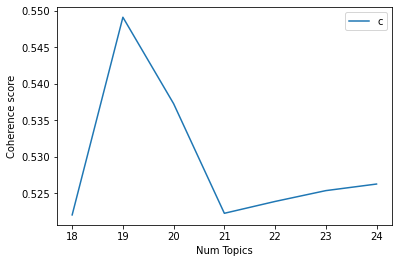

In [135]:
# Show graph
limit=25; start=18; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [136]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 18  has Coherence Value of 0.522
Num Topics = 19  has Coherence Value of 0.5491
Num Topics = 20  has Coherence Value of 0.5373
Num Topics = 21  has Coherence Value of 0.5223
Num Topics = 22  has Coherence Value of 0.5239
Num Topics = 23  has Coherence Value of 0.5254
Num Topics = 24  has Coherence Value of 0.5263


/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


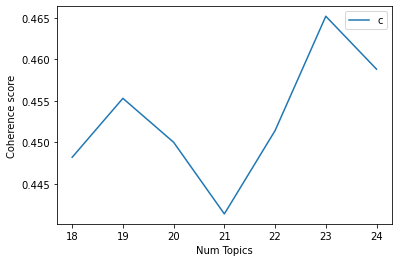

In [137]:
# Show graph
limit=25; start=18; step=1;
x = range(start, limit, step)
plt.plot(x, grammed_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [138]:
# Print the coherence scores
for m, cv in zip(x, grammed_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 18  has Coherence Value of 0.4482
Num Topics = 19  has Coherence Value of 0.4553
Num Topics = 20  has Coherence Value of 0.45
Num Topics = 21  has Coherence Value of 0.4414
Num Topics = 22  has Coherence Value of 0.4514
Num Topics = 23  has Coherence Value of 0.4652
Num Topics = 24  has Coherence Value of 0.4588


/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [139]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(model_list[1], corpus, words)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.189953  0.017513       1        1  15.568071
11    -0.273570  0.148206       2        1  12.357724
6     -0.195381  0.051421       3        1  11.697972
8     -0.028126 -0.147040       4        1   9.768223
17     0.140656  0.110235       5        1   9.665280
10    -0.056179 -0.135234       6        1   8.087839
15     0.044654 -0.119037       7        1   6.336864
18     0.195180  0.054491       8        1   5.602181
3      0.022554 -0.188408       9        1   4.233251
12    -0.014654  0.030604      10        1   2.502356
4      0.104417  0.096271      11        1   2.393184
14     0.043422 -0.034795      12        1   2.355134
13    -0.112911 -0.076866      13        1   2.034099
16     0.013951  0.129854      14        1   1.544099
9      0.049624  0.020791      15        1   1.503948
2     -0.081608 -0.013872      16        1   1.417839
7      0.061897  0.039154      17        1   1.303370
5      0.132793 -0.004273      18        1   1.027964
0      0.143233  0.020986      19        1   0.600603, topic_info=            Term          Freq         Total Category  logprob  loglift
213         loan  28754.000000  28754.000000  Default  30.0000  30.0000
239      officer  27282.000000  27282.000000  Default  29.0000  29.0000
32   application  15366.000000  15366.000000  Default  28.0000  28.0000
207      license  23477.000000  23477.000000  Default  27.0000  27.0000
715    applicant   8158.000000   8158.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
467    character     37.751853   3316.122781  Topic19  -4.8167   0.6395
471   confidence     36.296656   2708.900637  Topic19  -4.8560   0.8024
211         list     38.404885   5454.798157  Topic19  -4.7995   0.1589
252         page     37.461413   6541.806380  Topic19  -4.8244  -0.0477
57      business     36.738275   4838.109135  Topic19  -4.8439   0.2345

[1369 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1545      5  0.746457  00crb0115611
695       6  0.918749      132202a1
3841      2  0.058786       132203b
3841      6  0.176357       132203b
3841     12  0.352713       132203b
...     ...       ...           ...
406      16  0.005282          year
406      17  0.005942          year
406      18  0.000990          year
406      19  0.000660          year
1629      5  0.935874       yohance

[7602 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 12, 7, 9, 18, 11, 16, 19, 4, 13, 5, 15, 14, 17, 10, 3, 8, 6, 1])

In [140]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(grammed_model_list[5], corpus, words)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.084768  0.108554       1        1  13.451544
1     -0.121727 -0.006278       2        1  10.466391
21     0.014681  0.060778       3        1   9.317717
6     -0.260481 -0.089273       4        1   8.342087
22    -0.343632 -0.060684       5        1   8.087177
12     0.007749 -0.096651       6        1   6.661994
10     0.010272  0.091640       7        1   6.618141
19     0.004301  0.141706       8        1   4.828786
13    -0.026089  0.088944       9        1   4.193087
20    -0.018634  0.188159      10        1   4.059817
15     0.043621  0.189110      11        1   3.951543
5      0.190362 -0.174791      12        1   3.649781
14     0.084271  0.008519      13        1   3.095457
9      0.076391 -0.080125      14        1   3.045900
4      0.080841 -0.164757      15        1   2.086005
16    -0.131770 -0.109390      16        1   1.789102
11    -0.053038 -0.054913      17        1   1.759118
7     -0.072927 -0.007170      18        1   1.444861
2      0.006652 -0.020822      19        1   1.081467
0     -0.009283  0.108313      20        1   1.064392
18     0.179447 -0.107452      21        1   0.872772
17     0.145175 -0.059664      22        1   0.092650
3      0.109051  0.046247      23        1   0.040211, topic_info=          Term          Freq         Total Category  logprob  loglift
239    officer  31155.000000  31155.000000  Default  30.0000  30.0000
213       loan  34383.000000  34383.000000  Default  29.0000  29.0000
715  applicant   8950.000000   8950.000000  Default  28.0000  28.0000
207    license  26779.000000  26779.000000  Default  27.0000  27.0000
138    exhibit   8512.000000   8512.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
211       list      1.472473   5685.875950  Topic23  -5.3570  -0.4400
715  applicant      1.583411   8950.031565  Topic23  -5.2844  -0.8211
57    business      1.489331   6676.356530  Topic23  -5.3456  -0.5892
709    require      1.506200   8160.253861  Topic23  -5.3344  -0.7787
56      broker      1.415711   6525.313305  Topic23  -5.3963  -0.6170

[1548 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1545      6  0.615949  00crb0115611
453      15  0.584592       132153b
695      12  0.367712      132202a1
695      14  0.551568      132202a1
766      12  0.146908      1322031a
...     ...       ...           ...
406      21  0.000454          year
406      22  0.000151          year
406      23  0.000151          year
3871     19  0.321899        yellow
1629      6  0.823129       yohance

[7406 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 22, 7, 23, 13, 11, 20, 14, 21, 16, 6, 15, 10, 5, 17, 12, 8, 3, 1, 19, 18, 4])

In [75]:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [190]:
def format_topics_sentences(ldamodel=model_list[1], corpus=corpus, texts=text_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[1], corpus=corpus, texts=text_list)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

In [191]:
df_topic_sents_keywords["Dominant_Topic"] = df_topic_sents_keywords["Dominant_Topic"].apply(lambda x: mapping[x])

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: 19

In [195]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.loc[50]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 50
Dominant_Topic                                                                                                                                                                                                           

In [193]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9925,"loan, applicant, officer, license, agreement, settlement, year, fail, calendar, omba","[settlement, agreement, enter, basis, following, stipulation, admission, understanding, empower, 1322041b, renew, applicant, loan, officer, license, find, thing, applicant, comply, complete, minimum, hour, approve, continue, education, prior, calendar, year, authorize, refuse, renew, applicant, loan, officer, license, find, applicant, violate, fail, comply, provision, revise, rule, adopt, section, law, applicable, business, conduct, require, loan, officer, complete, hour, approve, continue, education, 31st, year, d, licensure, period, loan, officer, license, end, effort, renew, license, submit, renewal, application, remain, pende, e, admit, fail, complete, require, credit, hour, calendar, year, fail, comply, authority, refuse, renew, loan, officer, enter, settlement, agreement, lieu, formal, proceeding, deny, renewal, application, loan, ...]"
1,2,0.9922,"loan, license, officer, certificate, broker, require, registration, fail, suspension, section","[conduct, find, follow, order, renew, broker, certificate, registration, find, operation, manager, meet, experience, requirement, provide, section, revise, currently, designate, operation, manager, meet, requirement, outline, noncompliance, operation, manager, meet, experience, requirement, find, condition, renewal, outline, meet, authority, grant, compliance, refuse, renew, broker, certificate, registration, homein, d, order, renew, broker, certificate, registration, find, b2, operation, manager, designate, complete, immediately, precede, calendar, year, hour, continue, education, require, section, revise, operation, manager, fail, comply, complete, hour, continue, education, calendar, year, failure, meet, condition, renewal, outline, b2, authority, grant, compliance, refuse, renew, broker, certificate, registration, g, order, renew, broker, certificate, registration, find, comply, section, revise, ...]"
2,3,0.9944,"loan, officer, license, application, fail, renewal, deny, order, issue, find","[denial, loan, officer, license, renewal, superintendent, charge, responsibility, administer, enforce, broker, amend, bill, codify, revise, find, order, necessary, appropriate, interest, public, consistent, purpose, broker, issue, ray, loan, officer, license, loan, officer, license, expire, file, application, renew, loan, officer, license, renewal, application, remain, pende, issue, inform, conduct, thereof, allege, fail, comply, continue, education, requirement, fail, complete, hour, continue, education, calendar, year, fail, comply, continue, education, requirement, fail, complete, hour, continue, education, calendar, year, character, general, fitness, command, confidence, public, warrant, belief, business, operate, honestly, fairly, compliance, purpose, fail, comply, meet, condition, outline, authority, refuse, renew, loan, officer, license, informed, intent, deny, ...]"
3,4,0.9914,"report, application, officer, license, hearing, recommendation, order, loan, file, right","[chimney, denial, loan, officer, license, application, order, submit, loan, officer, license, application, issue, intend, deny, application, convict, theft, notify, right, hearing, matter, request, hearing, thereto, administrative, hearing, hold, accordance, revise, hearing, officer, file, write, report, recommendation, recommend, deny, serve, copy, report, recommendation, letter, explain, right, submit, written, objection, submit, letter, contain, objection, report, attach, letter, additional, letter, purport, reference, letter, objection, ask, consider, statement, letter, evidence, character, character, reference, request, new, hearing, accordance, consider, objection, review, new, evidence, submit, 9th, objection, letter, record, close, conclusion, administrative, hearing, additionally, request, new, hearing, deny, consideration, hearing, officer, report, recommendation, record,

In [194]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.head()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Num_Documents,Perc_Documents
1,961,0.1705
2,944,0.1675
3,874,0.1550
4,671,0.1190
5,528,0.0937
6,363,0.0644
7,331,0.0587
8,250,0.0443
9,169,0.0300
10,141,0.0250


In [181]:
df_dominant_topics.sort_values(by = ["Num_Documents"],ascending = False, inplace = True)
df_dominant_topics["Old Index"] = df_dominant_topics.index 
df_dominant_topics.reset_index(inplace = True)
mapping = df_dominant_topics[["Old Index"]].to_dict()['Old Index']
mapping = {value : key+1 for (key, value) in mapping.items()}
mapping

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{11.0: 1,
 6.0: 2,
 1.0: 3,
 10.0: 4,
 17.0: 5,
 18.0: 6,
 13.0: 7,
 8.0: 8,
 4.0: 9,
 15.0: 10,
 12.0: 11,
 3.0: 12,
 7.0: 13,
 0.0: 14,
 2.0: 15,
 16.0: 16,
 14.0: 17,
 5.0: 18,
 9.0: 19}